In [1]:
import pandas as pd
import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import pandas as pd
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
import matplotlib.pyplot as plt
import string
import re
import numpy as np
from sklearn.model_selection import train_test_split
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score, precision_score, accuracy_score

In [2]:
# use this do download stopwords if you haven't done this before
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dermotobrien/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# loading in dataframe, using special encoder parameter to save it correctly
df = pd.read_csv('twitter_data.csv',encoding= 'unicode_escape')

In [4]:
# renaming the columns
df = df.rename(columns={"tweet_text": "tweet", "emotion_in_tweet_is_directed_at": "subject", "is_there_an_emotion_directed_at_a_brand_or_product": "emotion"})

In [5]:
df['tweet'] = df['tweet'].str.lower()

In [6]:
df_binary = df.loc[(df['emotion'] == 'Positive emotion' ) | (df['emotion'] == 'Negative emotion' )]

In [7]:
df_binary.loc[df_binary['emotion'] == 'Positive emotion' , 'emotion_label'] = 0
df_binary.loc[df_binary['emotion'] == 'Negative emotion' , 'emotion_label'] = 1

/Users/dermotobrien/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/dermotobrien/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [8]:
# function to label new column based on the product category 

def label_brand(row):
    if row['subject'] == 'iPad':
        return 'Apple'
    elif row['subject'] == 'Apple':
        return 'Apple'
    elif row['subject'] == 'iPad or iPhone App':
        return 'Apple'
    elif row['subject'] == 'iPhone':
        return 'Apple'
    elif row['subject'] == 'Other Apple product or service':
        return 'Apple'
    elif row['subject'] == 'Google':
        return 'Google'
    elif row['subject'] == 'Other Google product or service':
        return 'Google'
    elif row['subject'] == 'Android App':
        return 'Google'
    elif row['subject'] == 'Android':
        return 'Google'
    elif row['subject'] == np.nan: 
        return np.nan

In [9]:
df_binary['company'] = df_binary.apply(lambda row: label_brand(row), axis=1)

<ipython-input-9-3c2e651705a5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_binary['company'] = df_binary.apply(lambda row: label_brand(row), axis=1)


In [10]:
apple_words = ['apple','ipad','iphone','itunes']
google_words = ['google','android']

In [11]:
df_binary.loc[(df_binary['subject'].isna()) & (df_binary['tweet'].str.contains('|'.join(apple_words))),'company'] = 'Apple'

In [12]:
df_binary.loc[(df_binary['subject'].isna()) & (df_binary['tweet'].str.contains('|'.join(google_words))),'company'] = 'Google'

In [13]:
df_binary.dropna(subset=['company'],inplace=True)

<ipython-input-13-7638a198be87>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_binary.dropna(subset=['company'],inplace=True)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(df_binary['tweet'], df_binary['emotion_label'], train_size=.9)

In [15]:
og_stopwords = stopwords.words('english')

## Baseline Model

In [16]:
tfidf_baseline = TfidfVectorizer(token_pattern=r"([a-zA-Z]+(?:'[a-z]+)?)",stop_words = og_stopwords)
baseline_vectorized = tfidf_baseline.fit_transform(X_train)

In [17]:
baseline_model = MultinomialNB()

In [18]:
# Evaluate the classifier on baseline_vectorized and y_train
baseline_cv = cross_val_score(baseline_model, baseline_vectorized, y_train)
baseline_cv.mean()

0.8454286504151733

In [19]:
# finding training score 
baseline_model.fit(baseline_vectorized,y_train)
baseline_train_score = baseline_model.score(baseline_vectorized,y_train)
print(baseline_train_score)

0.8586239396795476


In [20]:
#Evaluating recall
y_pred_baseline = baseline_model.predict(baseline_vectorized)
recall_score(y_train, y_pred_baseline)

0.11591355599214145

## Iteration 1: Decision Tree

In [21]:
tfidf_1 = TfidfVectorizer(token_pattern = r"([a-zA-Z]+(?:'[a-z]+)?)",stop_words = og_stopwords)
vectorized_1 = tfidf_1.fit_transform(X_train)

In [22]:
dt = DecisionTreeClassifier()

In [23]:
# Evaluate the classifier on basekube_vectorized and y_train
cv1 = cross_val_score(dt,vectorized_1, y_train)
cv1.mean()

0.8322373942320034

In [24]:
# finding training score 
dt.fit(vectorized_1,y_train)
dt1_score = dt.score(vectorized_1,y_train)
print(dt1_score)

0.9996858309770656


In [25]:
#Evaluating recall
y_pred_dt = dt.predict(baseline_vectorized)
recall_score(y_train, y_pred_baseline)

0.11591355599214145

## Iteration 2: Random Forest

In [26]:
tfidf_2 = TfidfVectorizer(token_pattern = r"([a-zA-Z]+(?:'[a-z]+)?)",stop_words = og_stopwords)
vectorized_2 = tfidf_2.fit_transform(X_train)

In [27]:
rf = RandomForestClassifier()

In [28]:
# Evaluate the random forest
cv2 = cross_val_score(rf,vectorized_2, y_train)
cv2.mean()

0.8705621871390067

In [29]:
# finding training score 
rf.fit(vectorized_2,y_train)
rf1_score = rf.score(vectorized_2,y_train)
print(rf1_score)

0.9996858309770656


In [30]:
#Evaluating recall
y_pred_rf = rf.predict(vectorized_2)
recall_score(y_train, y_pred_rf)

0.9980353634577603

## Iteration 3: Vectorizer 

In [31]:
tfidf_3 = TfidfVectorizer(token_pattern = r"([a-zA-Z]+(?:'[a-z]+)?)",
                          stop_words = og_stopwords,
                          ngram_range = (1,2),
                          min_df= 5
                         )
vectorized_3 = tfidf_3.fit_transform(X_train)

# five is the best input for our min_df parameter
# (1,2) is the best input for our ngram_range parameter

In [32]:
# Evaluate the random forest
cv3 = cross_val_score(rf,vectorized_3, y_train)
cv3.mean()

0.8715055833654215

In [33]:
# finding training score 
rf.fit(vectorized_3, y_train)
rf2_score = rf.score(vectorized_3, y_train)
print(rf2_score)

0.9996858309770656


In [34]:
#Evaluating recall
y_pred_rf2 = rf.predict(vectorized_3)
recall_score(y_train, y_pred_rf2)

0.9980353634577603

In [35]:
# looking at the shape of our tfidf sparse matrix
# pd.DataFrame.sparse.from_spmatrix(vectorized_3, columns=tfidf_3.get_feature_names()).shape

## Iteration 4 - Random Forest

In [36]:
tfidf_4 = TfidfVectorizer(token_pattern = r"([a-zA-Z]+(?:'[a-z]+)?)",
                          stop_words = og_stopwords,
                          ngram_range = (1,2),
                          min_df= 5
                         )
vectorized_4 = tfidf_4.fit_transform(X_train)

In [37]:
# grid search for random forest parameters
grid_rf1 = {"n_estimators":[100, 200, 300],
           "criterion": ["gini", "entropy", "log_loss"],
           "max_features": ["sqrt", "auto"],
           "max_depth" : [10,20,30,None],
            "min_samples_leaf" : [1,2,4],
            "min_samples_split": [2,5,10]
            }
GS_rf1 = GridSearchCV(
    estimator=rf,
    param_grid=grid_rf1,
    verbose=2)

In [38]:
# GS_rf1.fit(vectorized_4,y_train)

In [39]:
# GS_rf1.best_params_

{'criterion': 'gini',

'max_depth': None,

'max_features': 'auto',

'min_samples_leaf': 1,

'min_samples_split': 2,

'n_estimators': 200}

In [40]:
# GS_rf1.best_score_

0.8695299008634473

In [41]:
# grid search for random forest parameters
grid_rf2 = {"n_estimators":[150, 200, 250],
           "criterion": ["gini"],
           "max_features": ["auto"],
           "max_depth" : [None],
            "min_samples_leaf" : [1],
            "min_samples_split": [1,2,3]
            }
GS_rf2 = GridSearchCV(
    estimator=rf,
    param_grid=grid_rf2,
    n_jobs=-1,
    verbose=2)

In [42]:
GS_rf2.fit(vectorized_4,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   16.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   16.4s finished


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini'], 'max_depth': [None],
                         'max_features': ['auto'], 'min_samples_leaf': [1],
                         'min_samples_split': [1, 2, 3],
                         'n_estimators': [150, 200, 250]},
             verbose=2)

In [43]:
GS_rf2.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 150}

In [44]:
GS_rf2.best_score_

0.8740188383045526

In [45]:
# grid search for random forest parameters
grid_rf3 = {"n_estimators":[175, 200, 225],
           "criterion": ["gini"],
           "max_features": ["auto"],
           "max_depth" : [None],
            "min_samples_leaf" : [1],
            "min_samples_split": [3,4,5]
            }
GS_rf3 = GridSearchCV(
    estimator=rf,
    param_grid=grid_rf3,
    n_jobs=-1,
    verbose=2)

In [46]:
GS_rf3.fit(vectorized_4,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   20.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   20.0s finished


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini'], 'max_depth': [None],
                         'max_features': ['auto'], 'min_samples_leaf': [1],
                         'min_samples_split': [3, 4, 5],
                         'n_estimators': [175, 200, 225]},
             verbose=2)

In [47]:
GS_rf3.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 175}

In [48]:
GS_rf3.best_score_

0.8743308353820483

In [49]:
rf3 = RandomForestClassifier(n_estimators=225,
                             criterion="gini",
                             max_depth=None,
                             min_samples_split=3,
                             min_samples_leaf=1,
                             max_features="auto")

In [50]:
# Evaluate the random forest
cv4 = cross_val_score(rf3, vectorized_4, y_train)
cv4.mean()

0.8715060770316836

In [51]:
# finding training score 
rf3.fit(vectorized_4, y_train)
rf3_score = rf3.score(vectorized_4, y_train)
print(rf3_score)

0.9993716619541313


In [52]:
#Evaluating recall
y_pred_rf3 = rf3.predict(vectorized_4)
recall_score(y_train, y_pred_rf3)

0.9960707269155207

## Incorporating Additional Stopwords

In [53]:
word_eval = pd.concat([X_train, y_train], axis=1)
word_eval_pos = word_eval.loc[word_eval["emotion_label"] == 0]
word_eval_neg = word_eval.loc[word_eval["emotion_label"] == 1]

### Positive Words

In [54]:
tfidf_pos = TfidfVectorizer(token_pattern = r"([a-zA-Z]+(?:'[a-z]+)?)",
                          stop_words = og_stopwords,
                          ngram_range = (1,2), min_df=5)

In [55]:
pos_vec = tfidf_pos.fit_transform(word_eval_pos["tweet"])

In [56]:
pos_matrix = pd.DataFrame.sparse.from_spmatrix(pos_vec, columns=tfidf_pos.get_feature_names())

In [57]:
pos_words_sorted = list(pos_matrix.mean(axis=0).sort_values(ascending=False).head(10).index)

### Negative Words

In [58]:
tfidf_neg = TfidfVectorizer(token_pattern = r"([a-zA-Z]+(?:'[a-z]+)?)",
                          stop_words = og_stopwords,
                          ngram_range = (1,2), min_df=5)

In [59]:
neg_vec = tfidf_neg.fit_transform(word_eval_neg["tweet"])

In [60]:
neg_matrix = pd.DataFrame.sparse.from_spmatrix(neg_vec, columns=tfidf_neg.get_feature_names())

In [61]:
neg_words_sorted = list(neg_matrix.mean(axis=0).sort_values(ascending=False).head(10).index)

### Shared Words

In [62]:
pos_words_sorted

['mention',
 'sxsw',
 'ipad',
 'link',
 'apple',
 'rt',
 'rt mention',
 'google',
 'iphone',
 'store']

In [63]:
neg_words_sorted

['sxsw',
 'mention',
 'ipad',
 'iphone',
 'quot',
 'google',
 'apple',
 'rt mention',
 'rt',
 'link']

In [64]:
shared_words = [word for word in pos_words_sorted if word in neg_words_sorted]
shared_words

['mention',
 'sxsw',
 'ipad',
 'link',
 'apple',
 'rt',
 'rt mention',
 'google',
 'iphone']

In [65]:
updated_stopwords = og_stopwords.copy()
updated_stopwords.extend(['sxsw', 'mention', 'link', 'apple', 'google', 'quot', 'rt', 'rt mention'])

## Iteration 5 - Random Forest with updated stopwords

In [66]:
tfidf_5 = TfidfVectorizer(token_pattern = r"([a-zA-Z]+(?:'[a-z]+)?)",
                          stop_words = updated_stopwords,
                          ngram_range = (1,2),
                          min_df= 5)

vectorized_5 = tfidf_5.fit_transform(X_train)

In [67]:
rf5 = RandomForestClassifier(n_estimators=225,
                             criterion="gini",
                             max_depth=None,
                             min_samples_split=3,
                             min_samples_leaf=1,
                             max_features="auto")

In [68]:
# Evaluate the random forest
cv5 = cross_val_score(rf5, vectorized_5, y_train)
cv5.mean()

0.8743347847121432

In [69]:
# finding training score 
rf5.fit(vectorized_5, y_train)
rf5_score = rf5.score(vectorized_5, y_train)
print(rf5_score)

0.9956016336789193


In [70]:
# Evaluating recall
y_pred_rf5 = rf5.predict(vectorized_5)
recall_score(y_train, y_pred_rf5)

0.9764243614931237

### Recreate Positive and Negative Lists

#### Positive Words

In [71]:
tfidf_pos_2 = TfidfVectorizer(token_pattern = r"([a-zA-Z]+(?:'[a-z]+)?)",
                          stop_words = updated_stopwords,
                          ngram_range = (1,2), 
                          min_df=5)

pos_vec_2 = tfidf_pos_2.fit_transform(word_eval_pos["tweet"])

pos_matrix_2 = pd.DataFrame.sparse.from_spmatrix(pos_vec_2, columns=tfidf_pos_2.get_feature_names())

pos_words_sorted_2 = list(pos_matrix_2.mean(axis=0).sort_values(ascending=False).index)

In [72]:
# pos_words_sorted_2

#### Negative Words

In [73]:
tfidf_neg_2 = TfidfVectorizer(token_pattern = r"([a-zA-Z]+(?:'[a-z]+)?)",
                          stop_words = updated_stopwords,
                          ngram_range = (1,2), 
                          min_df=5)

neg_vec_2 = tfidf_neg_2.fit_transform(word_eval_neg["tweet"])

neg_matrix_2 = pd.DataFrame.sparse.from_spmatrix(neg_vec_2, columns=tfidf_neg_2.get_feature_names())

neg_words_sorted_2 = list(neg_matrix_2.mean(axis=0).sort_values(ascending=False).index)

In [74]:
# neg_words_sorted_2

## Wordcloud

In [75]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [76]:
from wordcloud import WordCloud
from PIL import Image

### Positive Wordcloud

In [77]:
pos_matrix_2.T.sum(axis=1).sort_values(ascending=False).head(30)

ipad          154.261066
iphone         93.213298
store          87.611800
app            72.289802
new            60.017910
austin         55.886309
pop            48.307474
android        47.128755
amp            42.560461
pop store      37.677955
party          37.379549
get            37.251081
great          34.116422
iphone app     31.830491
launch         31.785641
line           31.690117
via            30.300090
free           29.985305
i'm            29.846304
time           29.213916
awesome        28.794033
cool           28.553572
one            28.399600
like           27.154989
social         27.113704
maps           26.955008
w              26.766091
day            26.745361
circles        26.612371
mobile         26.230928
dtype: float64

In [78]:
pos_matrix_2.drop(['austin', 'pop', 'amp', 'get', 'circles', 'via', 'one', 'time', 'sxswi', "i'm"], axis=1, inplace=True)

In [79]:
custom_mask = np.array(Image.open("twitter_bw.png"))
pos_cloud = WordCloud(mask=custom_mask, 
                      background_color="white",
                      contour_color='black',
                      contour_width=3,
                      colormap='Greens', max_words=50).generate_from_frequencies(pos_matrix_2.T.sum(axis=1))

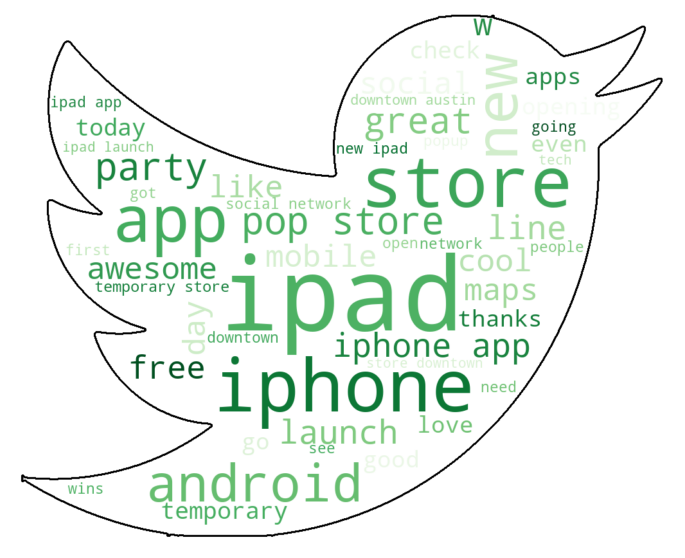

In [80]:
plt.figure(figsize=(15,10))
plt.imshow(pos_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

pos_cloud.to_file('./Results/Positive_wordcloud.png')

### Negative Wordcloud

In [81]:
neg_matrix_2.T.sum(axis=1).sort_values(ascending=False).head(30)

ipad                45.197328
iphone              41.005700
app                 19.658587
store               15.976939
like                12.665819
new                 12.003474
austin              11.580179
android             10.755196
design              10.473972
people              10.085603
circles             10.043613
apps                 9.770918
iphone app           9.657790
get                  9.440260
social               9.188535
time                 7.960138
amp                  7.866418
ipad design          7.602080
go                   7.496428
long                 7.471098
need                 7.348472
one                  7.312184
think                7.228861
pop                  7.198848
fail                 6.999505
headaches            6.839871
design headaches     6.839871
much                 6.572539
line                 6.554933
day                  6.499043
dtype: float64

In [82]:
neg_matrix_2.drop(['like', 'new', 'austin', 'iphone app', 'apps', 'circles', 'get', 'amp', 'says', 'one', 'time', 'would', 'go', "i'm"], axis=1, inplace=True)

In [83]:
custom_mask = np.array(Image.open("twitter_dieded.png"))
neg_cloud = WordCloud(mask=custom_mask, 
                      colormap='Reds', 
                      background_color="white",
                      contour_color='black',
                      contour_width=3,
                      max_words=50).generate_from_frequencies(neg_matrix_2.T.sum(axis=1))

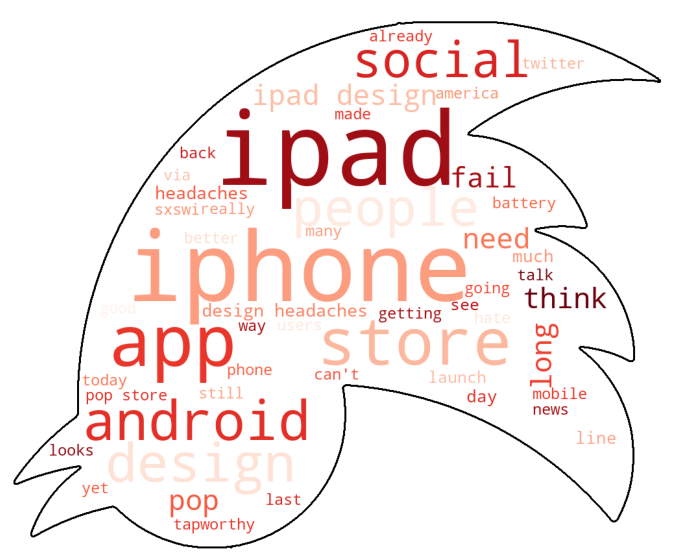

In [84]:
plt.figure(figsize=(15,10))
plt.clf()
plt.imshow(neg_cloud)
plt.axis('off')
plt.show()

neg_cloud.to_file('./Results/Negative_wordcloud.png')

## Iteration 6 - Random Forest max_depth adjustments

In [85]:
# Check max_depths of current random forest
[estimator.tree_.max_depth for estimator in rf5.estimators_]

[266,
 209,
 225,
 288,
 233,
 252,
 237,
 176,
 259,
 134,
 162,
 244,
 168,
 187,
 152,
 244,
 157,
 239,
 263,
 157,
 255,
 180,
 159,
 259,
 243,
 231,
 160,
 247,
 247,
 262,
 251,
 242,
 228,
 270,
 239,
 251,
 284,
 251,
 257,
 242,
 153,
 258,
 249,
 266,
 266,
 142,
 202,
 272,
 247,
 265,
 297,
 287,
 173,
 258,
 262,
 268,
 164,
 264,
 171,
 270,
 229,
 281,
 152,
 226,
 254,
 201,
 243,
 240,
 237,
 219,
 275,
 267,
 266,
 244,
 263,
 272,
 220,
 245,
 270,
 261,
 181,
 279,
 207,
 287,
 264,
 252,
 224,
 278,
 282,
 258,
 288,
 184,
 276,
 241,
 267,
 211,
 236,
 267,
 251,
 235,
 283,
 163,
 175,
 258,
 244,
 265,
 247,
 239,
 252,
 250,
 156,
 167,
 164,
 248,
 292,
 273,
 279,
 212,
 261,
 234,
 238,
 163,
 292,
 261,
 166,
 177,
 231,
 241,
 264,
 308,
 248,
 249,
 255,
 258,
 270,
 181,
 264,
 271,
 290,
 186,
 149,
 243,
 249,
 252,
 266,
 256,
 194,
 286,
 187,
 245,
 155,
 259,
 282,
 246,
 277,
 252,
 173,
 195,
 245,
 226,
 254,
 269,
 153,
 255,
 238,
 150,
 271

In [86]:
# grid search for random forest parameters
grid_rf4 = {"n_estimators":[225],
           "criterion": ["gini"],
           "max_features": ["auto"],
           "max_depth" : [50,100,150,200],
            "min_samples_leaf" : [1],
            "min_samples_split": [3]
            }
GS_rf4 = GridSearchCV(
    estimator=rf,
    param_grid=grid_rf4,
    n_jobs=-1,
    verbose=2,
    scoring='recall')

In [87]:
tfidf_6 = TfidfVectorizer(token_pattern = r"([a-zA-Z]+(?:'[a-z]+)?)",
                          stop_words = updated_stopwords,
                          ngram_range = (1,2),
                          min_df= 5,
                         )
vectorized_6 = tfidf_6.fit_transform(X_train)

In [88]:
GS_rf4.fit(vectorized_6, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:    4.9s remaining:    7.3s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   11.1s finished


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini'],
                         'max_depth': [50, 100, 150, 200],
                         'max_features': ['auto'], 'min_samples_leaf': [1],
                         'min_samples_split': [3], 'n_estimators': [225]},
             scoring='recall', verbose=2)

In [89]:
GS_rf4.best_params_

{'criterion': 'gini',
 'max_depth': 200,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 225}

In [90]:
GS_rf4.best_score_

0.3221122112211221

### Run Final Model on Test Set

In [91]:
test_vec = tfidf_5.transform(X_test)

In [92]:
# Evaluating recall
test_pred = rf5.predict(test_vec)
recall_score(y_test, test_pred)

0.38333333333333336

In [93]:
accuracy_score(y_test, test_pred)

0.867231638418079

In [94]:
precision_score(y_test, test_pred)

0.696969696969697

In [95]:
rf5.score(test_vec, y_test)

0.867231638418079

##### Find Tweets for TP, TN, FP, FN

In [105]:
y_pred = pd.Series(test_pred, name='predictions')

In [106]:
df_tweets = pd.concat([X_test, y_test], axis=1)

In [107]:
df_tweets.reset_index(inplace=True)
df_tweets.drop(['index'], axis=1, inplace=True)

In [110]:
tweets_df = df_tweets.merge(y_pred, left_index=True, right_index=True)

In [133]:
# True Negative (Correctly guessed positive sentiment)
TN_tweets = tweets_df.loc[(tweets_df['emotion_label'] == 0) & (tweets_df['predictions'] == 0)]

In [191]:
#52
TN_tweets['tweet'].head(50)[52]

'even the security guard at the popup apple store in austin loves the new ipad #sxsw  {link}'

In [120]:
# True Positives (Correctly guessed negative sentiment)
TP_tweets = tweets_df.loc[(tweets_df['emotion_label'] == 1) & (tweets_df['predictions'] == 1)]

In [156]:
TP_tweets['tweet'][177]

'i think my effing hubby is in line for an #ipad 2. can someone point him towards the line-up for wife number #2. #sxswi #sxsw'

In [158]:
# False Negatives (Incorrectly guess positive sentiment)
FN_tweets = tweets_df.loc[(tweets_df['emotion_label'] == 1) & (tweets_df['predictions'] == 0)]

In [164]:
FN_tweets['tweet'][283]

'pretty excited for my iphone to stop working #sxsw #at&amp;t'

In [122]:
# False Positives (Incorrectly guessed negative sentiment)
FP_tweets = tweets_df.loc[(tweets_df['emotion_label'] == 0) & (tweets_df['predictions'] == 1)]

In [184]:
FP_tweets['tweet']

"rt @mention nyt app for ipad: not &quot;here's an amazing way to serve our readership,&quot; more &quot;here's a market opportunity we can't ignore.&quot; #sxsw #newsapps"